# Production Estimation for BotWorld European Supply Chain

This notebook estimates the steady production rate that achieves 99% autonomy inventory for the European market.

## Task 3.1 Objectives:
1. Estimate 99%-robust steady daily production rate for each category cluster
2. Calculate prior start days to maintain 12-week (84-day) 99% autonomy

### Product Clusters:
- **Cluster 1**: Floor Care (F), Kitchen Help (K), Leisure (L)
- **Cluster 2**: Safety & Security (S), Wall & Window Care (W), Exterior Care (X)

### Key Methodology Update:
- Prior start days based on **MAXIMUM** 84-day autonomy requirement across entire year
- Accounts for Cyber Week demand surge (typically highest demand period)
- Ensures inventory can survive from Jan 1 through the year's critical period

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style('whitegrid')

## 1. Constants and Configuration

In [3]:
# US Holidays (hard-coded as per requirements)
# 11 holidays: New Year's, MLK, Presidents, Memorial, Independence, Labor,
# Columbus, Veterans, Thanksgiving, Day after Thanksgiving, Christmas
US_HOLIDAYS_PER_YEAR = 11
WORKDAYS_PER_YEAR = 365 - US_HOLIDAYS_PER_YEAR  # 354 workdays
AUTONOMY_DAYS = 84  # 12 weeks

# US Holidays by month (approximate - for workday counting)
# This is a simplified model: ~11 holidays spread across the year
HOLIDAY_RATE = US_HOLIDAYS_PER_YEAR / 365  # ~0.03

def count_workdays(num_calendar_days):
    """Estimate workdays from calendar days accounting for holidays"""
    return int(num_calendar_days * (1 - HOLIDAY_RATE))

def calendar_days_for_workdays(num_workdays):
    """Estimate calendar days needed for given workdays"""
    return int(np.ceil(num_workdays / (1 - HOLIDAY_RATE)))

## 2. Load Simulation Data

In [4]:
# Load all simulation batches
sim_batches_path = Path('sim_batches')
batch_files = sorted(sim_batches_path.glob('batch_*.csv.gz'))

print(f"Found {len(batch_files)} simulation batch files")
print("Loading simulation data...")

# Load all batches
all_sims = []
for batch_file in batch_files:
    df = pd.read_csv(batch_file, compression='gzip')
    all_sims.append(df)
    print(f"  Loaded {batch_file.name}")

sim_data = pd.concat(all_sims, ignore_index=True)
sim_data['date'] = pd.to_datetime(sim_data['date'])
sim_data['year'] = sim_data['date'].dt.year

print(f"\nLoaded {sim_data['sim'].nunique()} simulations")
print(f"Date range: {sim_data['date'].min()} to {sim_data['date'].max()}")
print(f"Total rows: {len(sim_data):,}")
print(f"Models: {sorted(sim_data['model'].unique())}")

Found 20 simulation batch files
Loading simulation data...
  Loaded batch_00.csv.gz
  Loaded batch_01.csv.gz
  Loaded batch_02.csv.gz
  Loaded batch_03.csv.gz
  Loaded batch_04.csv.gz
  Loaded batch_05.csv.gz
  Loaded batch_06.csv.gz
  Loaded batch_07.csv.gz
  Loaded batch_08.csv.gz
  Loaded batch_09.csv.gz
  Loaded batch_10.csv.gz
  Loaded batch_11.csv.gz
  Loaded batch_12.csv.gz
  Loaded batch_13.csv.gz
  Loaded batch_14.csv.gz
  Loaded batch_15.csv.gz
  Loaded batch_16.csv.gz
  Loaded batch_17.csv.gz
  Loaded batch_18.csv.gz
  Loaded batch_19.csv.gz

Loaded 100 simulations
Date range: 2027-01-01 00:00:00 to 2034-12-31 00:00:00
Total rows: 7,012,800
Models: ['F10', 'F20', 'F30', 'F50', 'K10', 'K20', 'K30', 'K50', 'L10', 'L20', 'L30', 'L50', 'S10', 'S20', 'S30', 'S50', 'W10', 'W20', 'W30', 'W50', 'X10', 'X20', 'X30', 'X50']


## 3. Create Product Cluster Aggregations

In [5]:
# Define cluster mapping
def get_cluster(model):
    """Map product model to cluster"""
    category = model[0]  # First letter indicates category
    if category in ['F', 'K', 'L']:
        return 'Cluster_1'
    elif category in ['S', 'W', 'X']:
        return 'Cluster_2'
    else:
        return 'Unknown'

# Add cluster column
sim_data['cluster'] = sim_data['model'].apply(get_cluster)

## 4. Calculate Annual Demand by Cluster

In [6]:
# Aggregate daily sales by cluster, year, and simulation

annual_cluster_demand = sim_data.groupby(['sim', 'year', 'cluster'])['sales_units'].sum().reset_index()
annual_cluster_demand.columns = ['sim', 'year', 'cluster', 'annual_sales']

# Calculate summary statistics across simulations
annual_stats = annual_cluster_demand.groupby(['year', 'cluster'])['annual_sales'].agg([
    'mean', 'std', 'min', 'max',
    ('p01', lambda x: np.percentile(x, 1)),
    ('p05', lambda x: np.percentile(x, 5)),
    ('p50', lambda x: np.percentile(x, 50)),
    ('p95', lambda x: np.percentile(x, 95)),
    ('p99', lambda x: np.percentile(x, 99))
]).reset_index()

print("\nAnnual demand statistics by cluster:")
print(annual_stats.round(2))


Annual demand statistics by cluster:
    year    cluster       mean      std        min        max        p01  \
0   2027  Cluster_1   16849.14   297.45   16088.33   17488.88   16113.38   
1   2027  Cluster_2   11270.96   297.45   10631.23   12031.77   10661.32   
2   2028  Cluster_1   40635.71   793.90   38812.63   43074.87   38840.75   
3   2028  Cluster_2   27154.90   793.90   24715.74   28977.98   25016.91   
4   2029  Cluster_1   85312.38  1448.68   81415.36   89343.02   82033.03   
5   2029  Cluster_2   56827.66  1448.68   52797.03   60724.69   53443.59   
6   2030  Cluster_1  127207.47  2295.95  120510.66  132413.90  121818.70   
7   2030  Cluster_2   84722.84  2295.95   79516.41   91419.65   80696.94   
8   2031  Cluster_1  151690.61  2697.50  146103.68  156901.14  146300.02   
9   2031  Cluster_2  102328.10  2697.50   97117.57  107915.03   97413.54   
10  2032  Cluster_1  167624.82  2959.62  158884.01  175747.04  162002.77   
11  2032  Cluster_2  112048.27  2959.62  103926.05

## 5. Calculate 99%-Robust Steady Daily Production Rate

In [7]:
print(f"\nCalculating 99%-robust daily production rates...")
print(f"Using {WORKDAYS_PER_YEAR} workdays per year\n")

production_rates = []

for year in sorted(annual_stats['year'].unique()):
    year_data = annual_stats[annual_stats['year'] == year]
    
    for cluster in ['Cluster_1', 'Cluster_2']:
        cluster_data = year_data[year_data['cluster'] == cluster]
        
        if len(cluster_data) > 0:
            # Use 99th percentile for 99% robustness
            annual_demand_p99 = cluster_data['p99'].values[0]
            annual_demand_mean = cluster_data['mean'].values[0]
            
            # Calculate daily production rate
            daily_rate_robust = annual_demand_p99 / WORKDAYS_PER_YEAR
            daily_rate_mean = annual_demand_mean / WORKDAYS_PER_YEAR
            
            production_rates.append({
                'year': year,
                'cluster': cluster,
                'annual_demand_mean': annual_demand_mean,
                'annual_demand_p99': annual_demand_p99,
                'daily_production_mean': daily_rate_mean,
                'daily_production_99robust': daily_rate_robust,
                'robustness_buffer_pct': ((annual_demand_p99 / annual_demand_mean) - 1) * 100
            })

production_rates_df = pd.DataFrame(production_rates)

print("99%-Robust Steady Daily Production Rates:")
print("="*100)
print(production_rates_df.to_string(index=False))

# Save to CSV
production_rates_df.to_csv('cluster_production_rates.csv', index=False)
print("\n✓ Production rates saved to cluster_production_rates.csv")


Calculating 99%-robust daily production rates...
Using 354 workdays per year

99%-Robust Steady Daily Production Rates:
 year   cluster  annual_demand_mean  annual_demand_p99  daily_production_mean  daily_production_99robust  robustness_buffer_pct
 2027 Cluster_1        16849.144591       17458.788815              47.596454                  49.318612               3.618250
 2027 Cluster_2        11270.961861       12006.726840              31.838875                  33.917307               6.527970
 2028 Cluster_1        40635.714897       42773.703731             114.790155                 120.829672               5.261354
 2028 Cluster_2        27154.897112       28949.861208              76.708749                  81.779269               6.610094
 2029 Cluster_1        85312.377579       88696.452831             240.995417                 250.554951               3.966687
 2029 Cluster_2        56827.664426       60107.016198             160.530125                 169.793831       

## 6. Calculate Daily Demand and Aggregate by Cluster

In [8]:
print("\nAggregating daily sales by cluster...")

# Aggregate daily sales by cluster across simulations
daily_cluster_sales = sim_data.groupby(['sim', 'date', 'cluster'])['sales_units'].sum().reset_index()

print(f"Created daily cluster sales aggregation: {len(daily_cluster_sales):,} rows")
print(f"Date range: {daily_cluster_sales['date'].min()} to {daily_cluster_sales['date'].max()}")


Aggregating daily sales by cluster...
Created daily cluster sales aggregation: 584,400 rows
Date range: 2027-01-01 00:00:00 to 2034-12-31 00:00:00


## 7. Calculate 84-Day Rolling Autonomy Requirements 

**Key Change**: Calculate autonomy for ALL dates in the year to find the maximum requirement.

This accounts for Cyber Week surge and other demand peaks.

In [9]:
print("\nCalculating 84-day rolling autonomy requirements...")
print("This will identify the maximum autonomy stress point in each year.\n")

autonomy_requirements = []

for cluster in ['Cluster_1', 'Cluster_2']:
    print(f"Processing {cluster}...")
    cluster_data = daily_cluster_sales[daily_cluster_sales['cluster'] == cluster].copy()
    
    for sim in sorted(cluster_data['sim'].unique()):
        sim_data_cluster = cluster_data[cluster_data['sim'] == sim].sort_values('date').copy()
        
        # Calculate rolling 84-day FORWARD cumulative sum
        sim_data_cluster = sim_data_cluster.set_index('date')
        
        # Forward-looking: sum of next 84 days
        sim_data_cluster['future_84day_demand'] = (
            sim_data_cluster['sales_units']
            .rolling(window=AUTONOMY_DAYS, min_periods=1)
            .sum()
            .shift(-AUTONOMY_DAYS + 1)
        )
        
        sim_data_cluster = sim_data_cluster.reset_index()
        autonomy_requirements.append(
            sim_data_cluster[['sim', 'date', 'cluster', 'future_84day_demand']]
        )
    
    print(f"  ✓ Completed {cluster}")

autonomy_df = pd.concat(autonomy_requirements, ignore_index=True)
autonomy_df = autonomy_df.dropna(subset=['future_84day_demand'])

print(f"\nTotal autonomy data points: {len(autonomy_df):,}")


Calculating 84-day rolling autonomy requirements...
This will identify the maximum autonomy stress point in each year.

Processing Cluster_1...
  ✓ Completed Cluster_1
Processing Cluster_2...
  ✓ Completed Cluster_2

Total autonomy data points: 567,800


In [10]:
# Calculate 99th percentile of 84-day demand for each date and cluster
print("\nCalculating P99 autonomy requirements for each date...")

autonomy_p99 = autonomy_df.groupby(['date', 'cluster'])['future_84day_demand'].agg(
    lambda x: np.percentile(x, 99)
).reset_index()
autonomy_p99.columns = ['date', 'cluster', 'autonomy_inventory_p99']
autonomy_p99['date'] = pd.to_datetime(autonomy_p99['date'])
autonomy_p99['year'] = autonomy_p99['date'].dt.year
autonomy_p99['day_of_year'] = autonomy_p99['date'].dt.dayofyear

print(f"Autonomy P99 data points: {len(autonomy_p99):,}")
print(f"\nSample of 12-week 99% autonomy requirements:")
print(autonomy_p99.head(20))


Calculating P99 autonomy requirements for each date...
Autonomy P99 data points: 5,678

Sample of 12-week 99% autonomy requirements:
         date    cluster  autonomy_inventory_p99  year  day_of_year
0  2027-01-01  Cluster_1             4004.441570  2027            1
1  2027-01-01  Cluster_2             2658.571996  2027            1
2  2027-01-02  Cluster_1             4020.910788  2027            2
3  2027-01-02  Cluster_2             2681.317392  2027            2
4  2027-01-03  Cluster_1             4031.890267  2027            3
5  2027-01-03  Cluster_2             2696.480990  2027            3
6  2027-01-04  Cluster_1             4035.184110  2027            4
7  2027-01-04  Cluster_2             2701.030069  2027            4
8  2027-01-05  Cluster_1             4005.820785  2027            5
9  2027-01-05  Cluster_2             2686.392721  2027            5
10 2027-01-06  Cluster_1             3976.457459  2027            6
11 2027-01-06  Cluster_2             2666.698536  

## 8. Calculate Prior Start Days 

**New Methodology**:
1. Find the **maximum** 84-day autonomy requirement across the entire year (likely before Cyber Week)
2. Calculate cumulative net production from Jan 1 to that critical date
3. Determine required inventory on Jan 1 to survive until critical date with sufficient autonomy
4. Calculate prior start days to build that Jan 1 inventory

### Why not considering later period autonomy?
becasue in the calendar the cyber week has the autonomy window till the end of the year (close), which means there will be no significant sales/ consumptions later for the year, making satisfying demand for that window (critical date one) equavelent to satisfying whole year requirements

In [11]:
print("\n" + "="*100)
print("CALCULATING PRIOR START DAYS - CORRECTED ALGORITHM")
print("="*100)

prior_start_days = []

for year in range(2027, 2035):
    jan1 = pd.Timestamp(f'{year}-01-01')
    
    print(f"\n{'='*80}")
    print(f"Year {year}")
    print(f"{'='*80}")
    
    for cluster in ['Cluster_1', 'Cluster_2']:
        print(f"\n  {cluster}:")
        
        # STEP 1: Find critical date with maximum autonomy requirement
        year_autonomy = autonomy_p99[
            (autonomy_p99['year'] == year) & 
            (autonomy_p99['cluster'] == cluster)
        ].copy()
        
        if len(year_autonomy) == 0:
            print("    ⚠ No data for this year/cluster")
            continue
        
        # Find maximum autonomy requirement
        max_idx = year_autonomy['autonomy_inventory_p99'].idxmax()
        critical_date = year_autonomy.loc[max_idx, 'date']
        max_autonomy = year_autonomy.loc[max_idx, 'autonomy_inventory_p99']
        critical_day_of_year = year_autonomy.loc[max_idx, 'day_of_year']
        
        print(f"    Critical date: {critical_date.strftime('%Y-%m-%d')} (day {critical_day_of_year})")
        print(f"    Max 84-day autonomy required: {max_autonomy:,.2f} units")
        
        # STEP 2: Calculate cumulative net production from Jan 1 to critical date
        days_jan1_to_critical = (critical_date - jan1).days
        workdays_to_critical = count_workdays(days_jan1_to_critical)
        
        # Get daily production rate for this year/cluster
        prod_rate = production_rates_df[
            (production_rates_df['year'] == year) & 
            (production_rates_df['cluster'] == cluster)
        ]
        
        if len(prod_rate) == 0:
            print("    ⚠ No production rate data")
            continue
        
        daily_production = prod_rate['daily_production_99robust'].values[0]
        cumulative_production = daily_production * workdays_to_critical
        
        print(f"    Days Jan1→Critical: {days_jan1_to_critical} ({workdays_to_critical} workdays)")
        print(f"    Cumulative production: {cumulative_production:,.2f} units")
        
        # Calculate cumulative demand P99 from Jan 1 to critical date
        jan1_to_critical_demands = []
        for sim in sorted(daily_cluster_sales['sim'].unique()):
            sim_cluster_data = daily_cluster_sales[
                (daily_cluster_sales['sim'] == sim) &
                (daily_cluster_sales['cluster'] == cluster) &
                (daily_cluster_sales['date'] >= jan1) &
                (daily_cluster_sales['date'] <= critical_date)
            ]
            demand_sum = sim_cluster_data['sales_units'].sum()
            jan1_to_critical_demands.append(demand_sum)
        
        cumulative_demand_p99 = np.percentile(jan1_to_critical_demands, 99)
        cumulative_net = cumulative_production - cumulative_demand_p99
        
        print(f"    Cumulative demand P99: {cumulative_demand_p99:,.2f} units")
        print(f"    Net accumulation: {cumulative_net:,.2f} units")
        
        # STEP 3: Calculate required inventory on Jan 1
        required_inventory_jan1 = max_autonomy - cumulative_net
        
        print(f"    Required inventory on Jan1: {required_inventory_jan1:,.2f} units")
        
        # STEP 4: Calculate prior start days
        workdays_needed = required_inventory_jan1 / daily_production
        prior_calendar_days = calendar_days_for_workdays(workdays_needed)
        start_date = jan1 - pd.Timedelta(days=prior_calendar_days)
        
        print(f"    Workdays needed: {workdays_needed:.1f}")
        print(f"    Prior start days: {prior_calendar_days} calendar days")
        print(f"    Production start date: {start_date.strftime('%Y-%m-%d')}")
        
        prior_start_days.append({
            'year': year,
            'cluster': cluster,
            'critical_date': critical_date,
            'critical_day_of_year': critical_day_of_year,
            'max_autonomy_required': max_autonomy,
            'days_jan1_to_critical': days_jan1_to_critical,
            'workdays_jan1_to_critical': workdays_to_critical,
            'cumulative_production_jan1_to_critical': cumulative_production,
            'cumulative_demand_p99_jan1_to_critical': cumulative_demand_p99,
            'net_accumulation_jan1_to_critical': cumulative_net,
            'required_inventory_jan1': required_inventory_jan1,
            'daily_production_rate': daily_production,
            'workdays_needed_for_prior': workdays_needed,
            'prior_start_days': prior_calendar_days,
            'production_start_date': start_date
        })

prior_start_df = pd.DataFrame(prior_start_days)

print("\n" + "="*100)
print("PRIOR START DAYS SUMMARY")
print("="*100)
print(prior_start_df[[
    'year', 'cluster', 'critical_date', 'max_autonomy_required',
    'required_inventory_jan1', 'prior_start_days', 'production_start_date'
]].to_string(index=False))

# Save to CSV
prior_start_df.to_csv('prior_start_days_corrected.csv', index=False)
print("\n✓ Prior start days saved to prior_start_days_corrected.csv")


CALCULATING PRIOR START DAYS - CORRECTED ALGORITHM

Year 2027

  Cluster_1:
    Critical date: 2027-11-26 (day 330)
    Max 84-day autonomy required: 9,228.98 units
    Days Jan1→Critical: 329 (319 workdays)
    Cumulative production: 15,732.64 units
    Cumulative demand P99: 14,639.08 units
    Net accumulation: 1,093.56 units
    Required inventory on Jan1: 8,135.42 units
    Workdays needed: 165.0
    Prior start days: 171 calendar days
    Production start date: 2026-07-14

  Cluster_2:
    Critical date: 2027-11-26 (day 330)
    Max 84-day autonomy required: 6,158.96 units
    Days Jan1→Critical: 329 (319 workdays)
    Cumulative production: 10,819.62 units
    Cumulative demand P99: 9,672.35 units
    Net accumulation: 1,147.27 units
    Required inventory on Jan1: 5,011.69 units
    Workdays needed: 147.8
    Prior start days: 153 calendar days
    Production start date: 2026-08-01

Year 2028

  Cluster_1:
    Critical date: 2028-11-24 (day 329)
    Max 84-day autonomy require

## 9. Visualizations

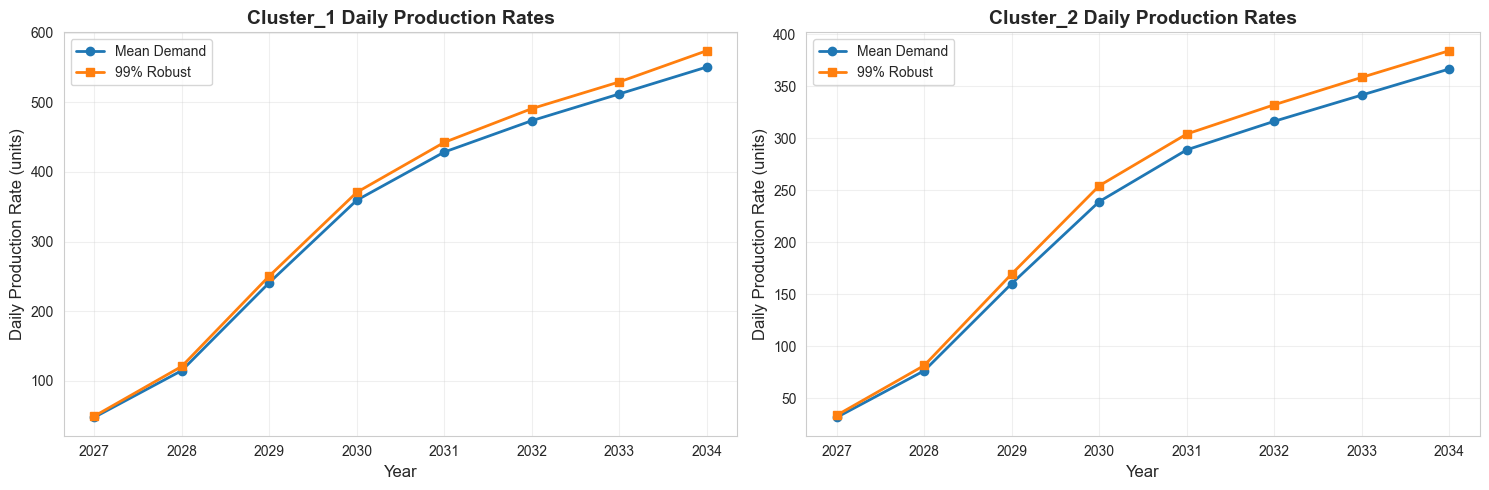

✓ Saved daily_production_rates.png


In [ ]:
# Plot 1: Daily Production Rates
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for idx, cluster in enumerate(['Cluster_1', 'Cluster_2']):
    cluster_prod = production_rates_df[production_rates_df['cluster'] == cluster]
    
    axes[idx].plot(cluster_prod['year'], cluster_prod['daily_production_mean'], 
                   marker='o', label='Mean Demand', linewidth=2)
    axes[idx].plot(cluster_prod['year'], cluster_prod['daily_production_99robust'], 
                   marker='s', label='99% Robust', linewidth=2)
    
    axes[idx].set_xlabel('Year', fontsize=12)
    axes[idx].set_ylabel('Daily Production Rate (units)', fontsize=12)
    axes[idx].set_title(f'{cluster} Daily Production Rates', fontsize=14, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

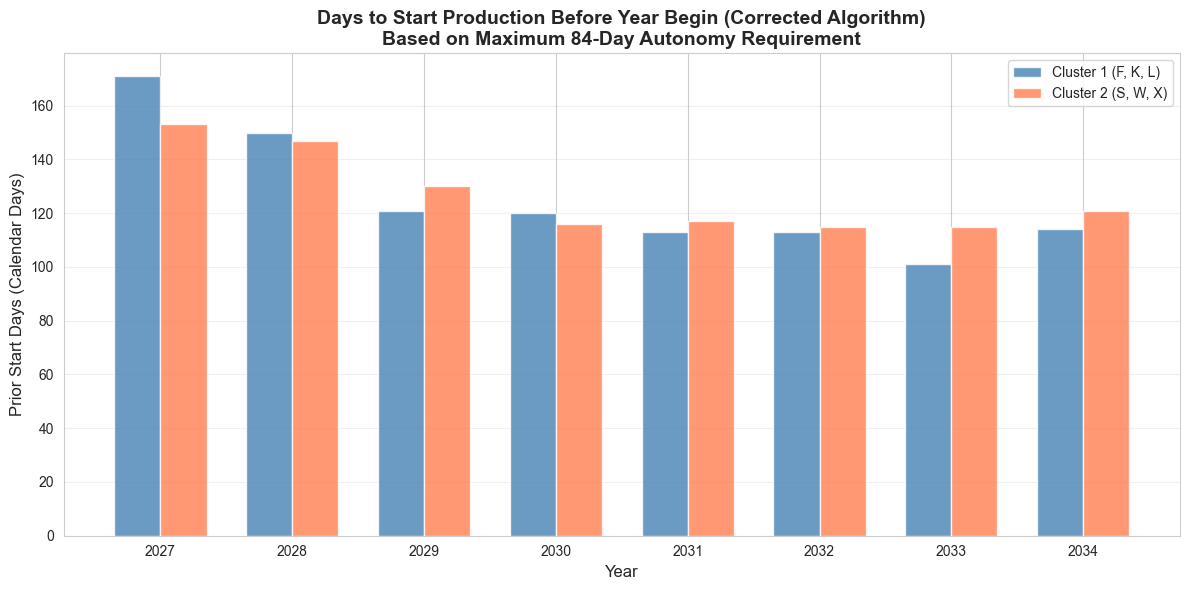

✓ Saved prior_start_days_corrected.png


In [ ]:
# Plot 2: Prior Start Days
fig, ax = plt.subplots(figsize=(12, 6))

years = sorted(prior_start_df['year'].unique())
x = np.arange(len(years))
width = 0.35

cluster1_data = prior_start_df[prior_start_df['cluster'] == 'Cluster_1'].sort_values('year')
cluster2_data = prior_start_df[prior_start_df['cluster'] == 'Cluster_2'].sort_values('year')

ax.bar(x - width/2, cluster1_data['prior_start_days'], width, 
       label='Cluster 1 (F, K, L)', alpha=0.8, color='steelblue')
ax.bar(x + width/2, cluster2_data['prior_start_days'], width, 
       label='Cluster 2 (S, W, X)', alpha=0.8, color='coral')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Prior Start Days (Calendar Days)', fontsize=12)
ax.set_title('Days to Start Production Before Year Begin (Corrected Algorithm)\n'
             'Based on Maximum 84-Day Autonomy Requirement', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

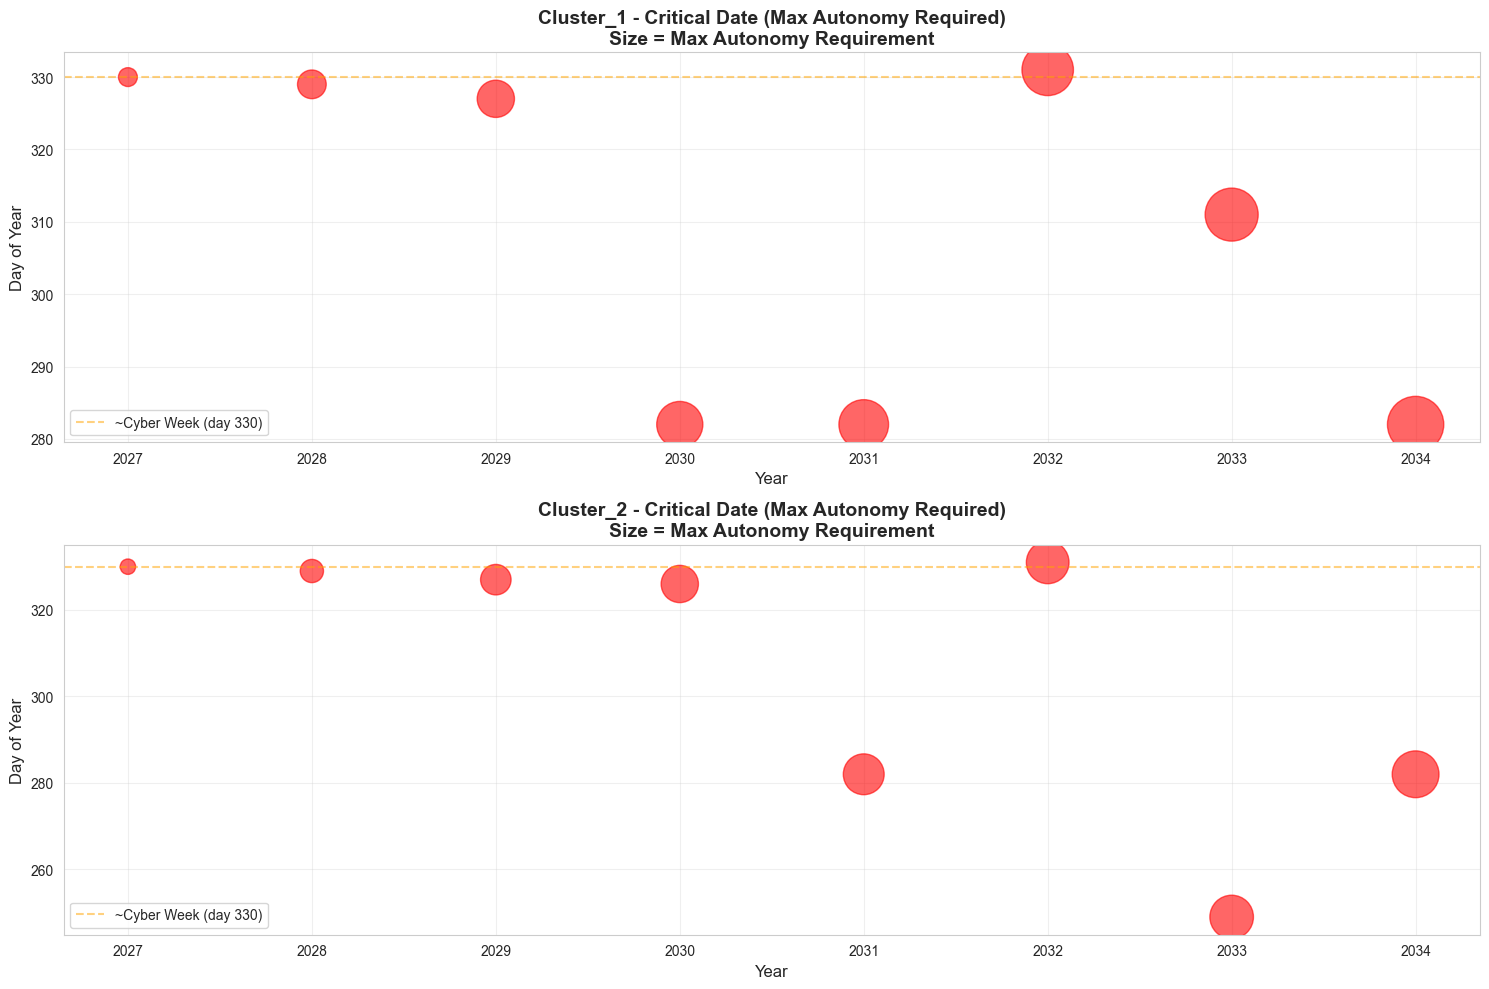

✓ Saved critical_dates_analysis.png


In [ ]:
# Plot 3: Critical Dates Analysis
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

for idx, cluster in enumerate(['Cluster_1', 'Cluster_2']):
    cluster_prior = prior_start_df[prior_start_df['cluster'] == cluster].sort_values('year')
    
    axes[idx].scatter(cluster_prior['year'], cluster_prior['critical_day_of_year'],
                     s=cluster_prior['max_autonomy_required']/50, alpha=0.6, c='red')
    
    axes[idx].set_xlabel('Year', fontsize=12)
    axes[idx].set_ylabel('Day of Year', fontsize=12)
    axes[idx].set_title(f'{cluster} - Critical Date (Max Autonomy Required)\n'
                       'Size = Max Autonomy Requirement', 
                       fontsize=14, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axhline(y=330, color='orange', linestyle='--', alpha=0.5, label='~Cyber Week (day 330)')
    axes[idx].legend()

plt.tight_layout()
# plt.savefig('../Plots/critical_dates_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
# print("✓ Saved critical_dates_analysis.png")

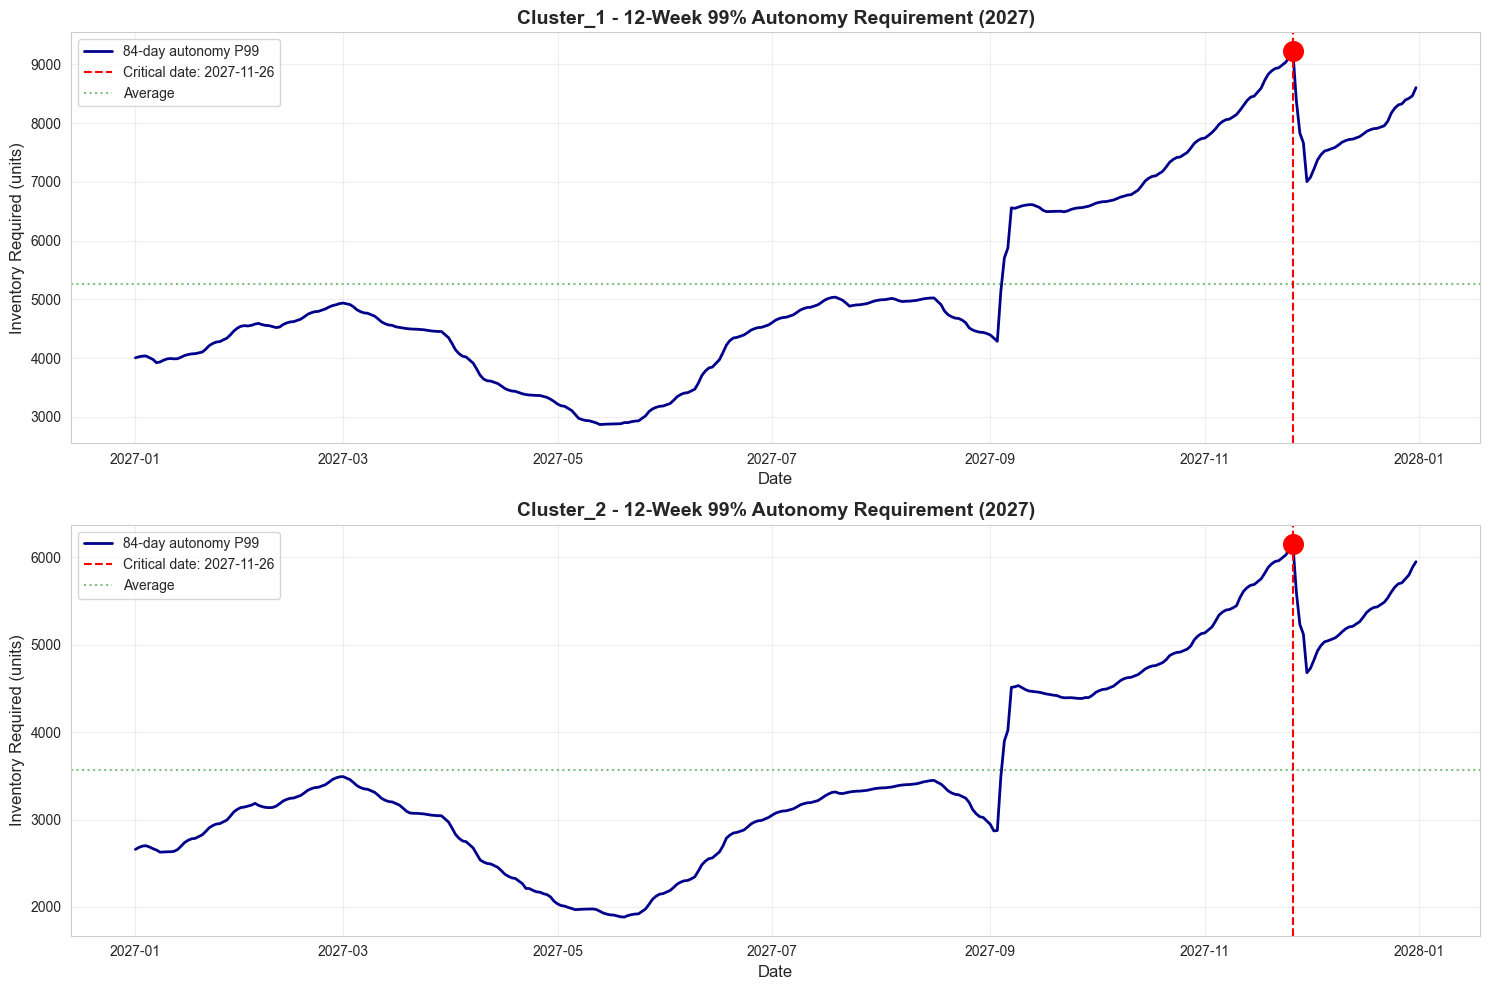

✓ Saved autonomy_inventory_2027_corrected.png


In [ ]:
# Plot 4: Autonomy Requirements Over Time (2027 example)
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

year_to_plot = 2027
autonomy_year = autonomy_p99[autonomy_p99['year'] == year_to_plot]

for idx, cluster in enumerate(['Cluster_1', 'Cluster_2']):
    cluster_autonomy = autonomy_year[autonomy_year['cluster'] == cluster].sort_values('date')
    
    axes[idx].plot(cluster_autonomy['date'], cluster_autonomy['autonomy_inventory_p99'], 
                   linewidth=2, color='darkblue', label='84-day autonomy P99')
    
    # Mark critical date
    cluster_critical = prior_start_df[
        (prior_start_df['year'] == year_to_plot) & 
        (prior_start_df['cluster'] == cluster)
    ]
    if len(cluster_critical) > 0:
        critical_date = cluster_critical['critical_date'].values[0]
        max_autonomy = cluster_critical['max_autonomy_required'].values[0]
        axes[idx].axvline(x=critical_date, color='red', linestyle='--', 
                         label=f'Critical date: {pd.Timestamp(critical_date).strftime("%Y-%m-%d")}')
        axes[idx].scatter([critical_date], [max_autonomy], s=200, c='red', zorder=5)
    
    axes[idx].axhline(y=cluster_autonomy['autonomy_inventory_p99'].mean(), 
                      color='green', linestyle=':', alpha=0.5, label='Average')
    
    axes[idx].set_xlabel('Date', fontsize=12)
    axes[idx].set_ylabel('Inventory Required (units)', fontsize=12)
    axes[idx].set_title(f'{cluster} - 12-Week 99% Autonomy Requirement ({year_to_plot})', 
                        fontsize=14, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('../Plots/autonomy_inventory_2027_corrected.png', dpi=300, bbox_inches='tight')
plt.show()
# print("✓ Saved autonomy_inventory_2027_corrected.png")

## 10. Summary Report

In [17]:
print("\n" + "="*120)
print("TASK 3.1 SUMMARY: PRODUCTION PLANNING FOR 99% AUTONOMY (CORRECTED)")
print("="*120)
print("\n📊 KEY FINDINGS:\n")

print("1. METHODOLOGY CORRECTION")
print("   ✓ Prior start days now based on MAXIMUM 84-day autonomy across entire year")
print("   ✓ Accounts for Cyber Week and other demand surges")
print("   ✓ Ensures inventory sufficiency from Jan 1 through critical peak period\n")

print("2. STEADY DAILY PRODUCTION RATES (99%-Robust)\n")
print("   Cluster 1 (Floor Care, Kitchen Help, Leisure):")
cluster1_summary = production_rates_df[production_rates_df['cluster'] == 'Cluster_1']
for _, row in cluster1_summary.head(3).iterrows():
    print(f"   - {int(row['year'])}: {row['daily_production_99robust']:.2f} units/day")

print("\n   Cluster 2 (Safety & Security, Wall & Window Care, Exterior Care):")
cluster2_summary = production_rates_df[production_rates_df['cluster'] == 'Cluster_2']
for _, row in cluster2_summary.head(3).iterrows():
    print(f"   - {int(row['year'])}: {row['daily_production_99robust']:.2f} units/day")

print("\n3. PRIOR START DAYS (Based on Maximum Autonomy Requirement)\n")
print("   Cluster 1:")
cluster1_prior = prior_start_df[prior_start_df['cluster'] == 'Cluster_1']
for _, row in cluster1_prior.head(3).iterrows():
    print(f"   - {int(row['year'])}: Start {int(row['prior_start_days'])} days before Jan 1 "
          f"(Critical date: {pd.Timestamp(row['critical_date']).strftime('%b %d')})")

print("\n   Cluster 2:")
cluster2_prior = prior_start_df[prior_start_df['cluster'] == 'Cluster_2']
for _, row in cluster2_prior.head(3).iterrows():
    print(f"   - {int(row['year'])}: Start {int(row['prior_start_days'])} days before Jan 1 "
          f"(Critical date: {pd.Timestamp(row['critical_date']).strftime('%b %d')})")

print("\n4. CRITICAL DATES (Where Maximum Autonomy is Required)\n")
avg_critical_day = prior_start_df['critical_day_of_year'].mean()
print(f"   Average critical day of year: {avg_critical_day:.0f} (~{pd.Timestamp('2027-01-01') + pd.Timedelta(days=int(avg_critical_day)):%B %d})")
print("   Note: Typically aligns with pre-Cyber Week period (late November)")


TASK 3.1 SUMMARY: PRODUCTION PLANNING FOR 99% AUTONOMY (CORRECTED)

📊 KEY FINDINGS:

1. METHODOLOGY CORRECTION
   ✓ Prior start days now based on MAXIMUM 84-day autonomy across entire year
   ✓ Accounts for Cyber Week and other demand surges
   ✓ Ensures inventory sufficiency from Jan 1 through critical peak period

2. STEADY DAILY PRODUCTION RATES (99%-Robust)

   Cluster 1 (Floor Care, Kitchen Help, Leisure):
   - 2027: 49.32 units/day
   - 2028: 120.83 units/day
   - 2029: 250.55 units/day

   Cluster 2 (Safety & Security, Wall & Window Care, Exterior Care):
   - 2027: 33.92 units/day
   - 2028: 81.78 units/day
   - 2029: 169.79 units/day

3. PRIOR START DAYS (Based on Maximum Autonomy Requirement)

   Cluster 1:
   - 2027: Start 171 days before Jan 1 (Critical date: Nov 26)
   - 2028: Start 150 days before Jan 1 (Critical date: Nov 24)
   - 2029: Start 121 days before Jan 1 (Critical date: Nov 23)

   Cluster 2:
   - 2027: Start 153 days before Jan 1 (Critical date: Nov 26)
   - 2